In [ ]:
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
%%shell
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
%%shell
wget https://raw.githubusercontent.com/luonghuuthanhnam/object_detection/master/coco_eval.py
wget https://raw.githubusercontent.com/luonghuuthanhnam/object_detection/master/coco_utils.py
wget https://raw.githubusercontent.com/luonghuuthanhnam/object_detection/master/engine.py
wget https://raw.githubusercontent.com/luonghuuthanhnam/object_detection/master/transforms.py
wget https://raw.githubusercontent.com/luonghuuthanhnam/object_detection/master/utils.py

In [1]:
import json
import random
import utils
from engine import train_one_epoch, evaluate
import transforms as T
import cv2
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os
import numpy as np
import torch
from PIL import Image
import random
root_dir = "/content/drive/MyDrive/task2"
img_dir = "/content/drive/MyDrive/task2/dataset/images/"

In [2]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

dataset_raw= json.load(open("/content/drive/MyDrive/task2/dataset_raw.json"))
data_object = dataset_raw["data"]

no_bounding_img = []
for i in range(len(data_object)):
    data_object[i]["id"] = i
    if len(data_object[i]["boxes"]) == 0:
        no_bounding_img.append(i)

delete_multiple_element(data_object, no_bounding_img)
random.shuffle(data_object)

In [6]:
class Custom_dataset(torch.utils.data.Dataset):
    def __init__(self, data, image_dir, transforms, shuffle = True):
        self.root = image_dir
        self.transforms = transforms
        self.data_object = data.copy()
        if shuffle:
            random.shuffle(self.data_object)

    def __getitem__(self, idx):
        # load images and masks
        data_point = self.data_object[idx]
        img_name = data_point["imageName"]
        img_path = os.path.join(self.root, img_name)
        
        img = Image.open(img_path).convert("RGB")
        boxes = []
        for box in data_point["boxes"]:
            xtl = box["bbox"]["xtl"]
            xbr = box["bbox"]["xbr"]
            ytl = box["bbox"]["ytl"]
            ybr = box["bbox"]["ybr"]
            boxes.append([xtl, ytl, xbr, ybr])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        image_id = torch.tensor([data_point["id"]])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data_object)


In [7]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.2))
        transforms.append(T.RandomScale(0.7))
        transforms.append(T.RandomColor(0.3))
        transforms.append(T.Blur(prob=0.5, blur_range=(0,1)))
        transforms.append(T.GaussNoise(0.2, mean = 0, std = 10, auto= True))
    return T.Compose(transforms)

In [9]:
def visualize_image(img, prediction):
    opencvImage = img
    if type(img) is not np.ndarray:
        opencvImage = cv2.cvtColor(np.array(opencvImage), cv2.COLOR_RGB2BGR)
        # opencvImage = np.array(opencvImage)
    for idx, bbox in enumerate(prediction[0]["boxes"]):
        bbox = np.array(bbox.tolist(), dtype=int)
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        opencvImage = cv2.rectangle(opencvImage, start_point, end_point, (0,0,255), 1)
    return opencvImage

In [10]:
def get_instance_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                                trainable_backbone_layers=3,
                                                                rpn_pre_nms_top_n_train=1000,
                                                                rpn_pre_nms_top_n_test = 1000,
                                                                rpn_post_nms_top_n_train = 1000,
                                                                rpn_post_nms_top_n_test = 1000,
                                                                rpn_nms_thresh = 0.5,
                                                                box_score_thresh = 0.5,
                                                                box_detections_per_img = 50,#
                                                                rpn_batch_size_per_image = 1000,
                                                                box_batch_size_per_image = 1000
                                                                )

    return model

In [14]:
torch.manual_seed(1)
train_test_thresh = int((len(data_object))*0.8)
dataset = Custom_dataset(data_object[:train_test_thresh], img_dir, get_transform(train=True), True)
dataset_test = Custom_dataset(data_object[train_test_thresh:], img_dir, get_transform(train=False), True)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

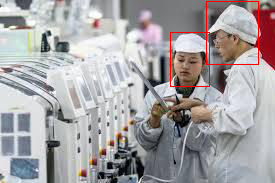

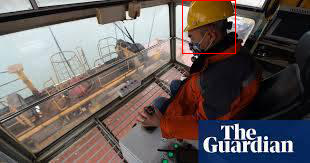

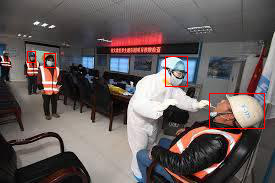

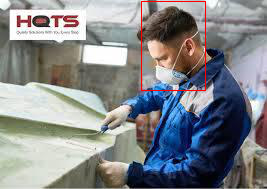

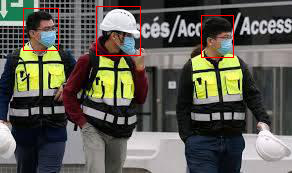

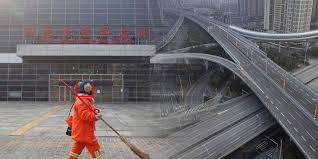

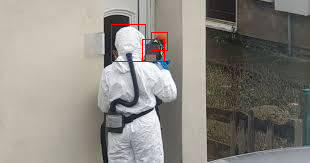

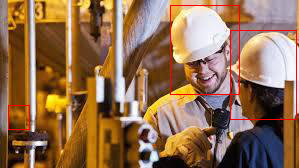

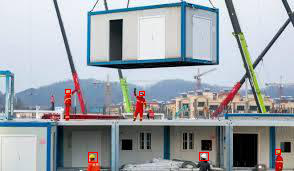

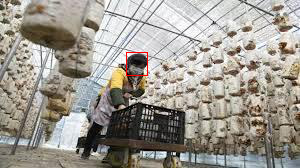

In [15]:
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm_notebook
toTensor = T.ToTensor()
for i in tqdm_notebook(range(0, 10)):
    img, target, img_id = "","",""
    img, target = dataset_test[i]
    new_img = T.tensor_to_PIL(img)
    img_id = target["image_id"]
    new_img = visualize_image(new_img, [target])
    w,h,_ = np.array(new_img).shape
    expected_height = 768
    expected_width = 0
    if h > 768:
        ratio = expected_height/h
        expected_width = int(ratio*w)
        new_img = cv2.resize(np.array(new_img), (expected_height, expected_width))
    cv2_imshow(new_img)

In [58]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

print(f"Num class: {num_classes}")
model = get_instance_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.003)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)

Num class: 2


In [59]:
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    if (epoch+1) % 1==0:
      evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/208]  eta: 0:01:50  lr: 0.000029  loss: 0.2898 (0.2898)  loss_classifier: 0.1924 (0.1924)  loss_box_reg: 0.0362 (0.0362)  loss_objectness: 0.0567 (0.0567)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 0.5300  data: 0.1543  max mem: 5237
Epoch: [0]  [ 50/208]  eta: 0:01:13  lr: 0.001236  loss: 0.1191 (0.2032)  loss_classifier: 0.0492 (0.1174)  loss_box_reg: 0.0385 (0.0487)  loss_objectness: 0.0160 (0.0327)  loss_rpn_box_reg: 0.0024 (0.0044)  time: 0.3622  data: 0.0067  max mem: 5237
Epoch: [0]  [100/208]  eta: 0:00:47  lr: 0.002442  loss: 0.1051 (0.1698)  loss_classifier: 0.0508 (0.0870)  loss_box_reg: 0.0382 (0.0499)  loss_objectness: 0.0108 (0.0265)  loss_rpn_box_reg: 0.0030 (0.0063)  time: 0.4393  data: 0.0766  max mem: 5237
Epoch: [0]  [150/208]  eta: 0:00:24  lr: 0.003649  loss: 0.0783 (0.1510)  loss_classifier: 0.0309 (0.0740)  loss_box_reg: 0.0288 (0.0479)  loss_objectness: 0.0078 (0.0228)  loss_rpn_box_reg: 0.0010 (0.0063)  time: 0.3633  data: 0.0067  max mem: 5237


In [60]:
def test_on_eval_set(model , n_sample, dataset_test, transform):
    model.eval()
    list_idx = list(range(len(dataset_test)))
    random.shuffle(list_idx)
    for i in tqdm_notebook(range(0, n_sample)):
        img, target, img_id = "","",""
        img, target = dataset_test[list_idx[i]]
        new_img = T.tensor_to_PIL(img)
        img_tensor, _ = transform(new_img, "")
        import time
        start_time = time.time()
        prediction = ''
        with torch.no_grad():
            prediction = model([img_tensor.to(device)])
        print("predict_time: ", time.time() - start_time)
        im  = visualize_image(new_img, prediction)
        cv2_imshow(im)

  0%|          | 0/5 [00:00<?, ?it/s]

predict_time:  0.09477734565734863


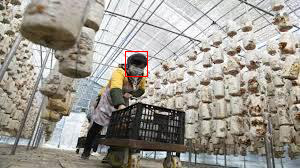

predict_time:  0.06679630279541016


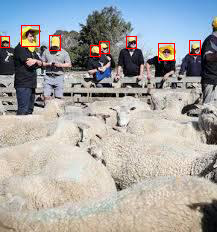

predict_time:  0.07787561416625977


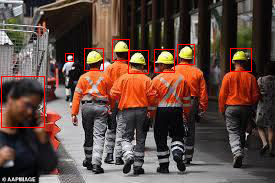

predict_time:  0.077484130859375


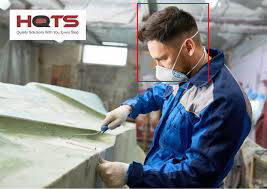

predict_time:  0.07962560653686523


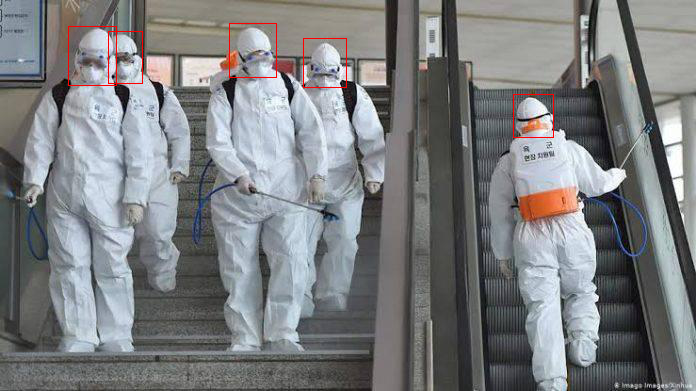

In [61]:
trans = get_transform(train = False)
test_on_eval_set(model, 5, dataset_test, trans)

In [62]:
torch.save(model,"head_detector.pth")
# model = torch.load("head_detector.pth")

In [92]:
def test_infer(model, img_path, transform):
    img = Image.open(img_path)
    if img.mode == "RGBA":
        img = img.convert("RGB")
    img_tensor, _ = transform(img, "")
    import time
    start_time = time.time()
    prediction = ''
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])
    print("predict_time: ", time.time() - start_time)

    im  = visualize_image(img, prediction)
    cv2_imshow(im)
    return prediction

predict_time:  0.07928752899169922


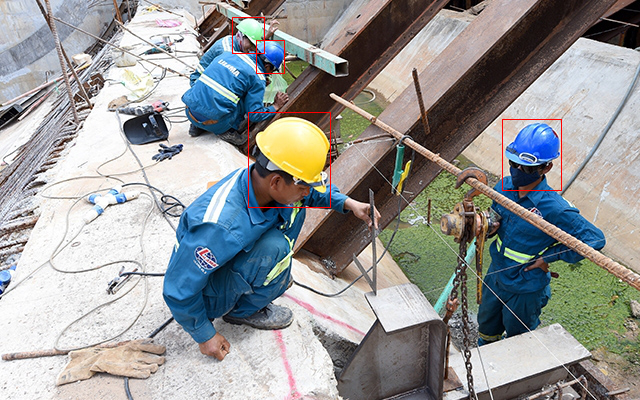

In [93]:
pred =test_infer(model, "test1.jpg", get_transform(False))